In [213]:
import IPython.display as ipd
import sounddevice as sd
import soundfile as sf
import librosa
import librosa.display
from IPython.display import Audio
import numpy
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import os
import scipy.signal
import matplotlib.pyplot as plt

from joblib import load, dump

## Chargement des fichiers audios

In [297]:
# Chargement des différents fichiers audio

aissa_audios = []

for file in os.listdir("Aissa"):

    # Charger l'audio dans la liste aissa audios
    audio_aissa, sr_aissa = librosa.load("Aissa/" + file)
    aissa_audios.append(audio_aissa)



marouan_audios = []

for file in os.listdir("Marouan"):
    # Changer l'audio dans la liste marouan audios
    audio_marouan, sr_marouan = librosa.load("Marouan/" + file)
    marouan_audios.append(audio_marouan)



autre_audios = []

for file in os.listdir("Autre"):
    # Changer l'audio dans la liste autre audios
    audio_autre, sr_autre = librosa.load("Autre/" + file)
    autre_audios.append(audio_autre)


## Preprocessing

In [298]:
# Preprocessing the audios : bandpass filter + remove silences
def pretraitment(sound):
    sound_filtered = pass_band_filter(sound)
    sound_no_silence = remove_silence(sound_filtered)
    return sound_no_silence

def remove_silence(signal):
    # extract non-silent intervals from the voice signal
    voice_intervals = librosa.effects.split(signal, frame_length=2048, top_db=35, hop_length=512)
    voice_no_silence = np.array([])
    slices = [signal[interval[0]:interval[1]] for interval in voice_intervals]
    voice_no_silence = np.concatenate(slices)
    return voice_no_silence

def pass_band_filter(sound, sr_sound=22050):
    # design a filter to remove the background noise using `scipy.signal.iirfilter`
    b, a = scipy.signal.iirfilter(1, [128, 2048], btype="bandpass", fs=sr_sound)

    # apply the filter using `scipy.signal.lfilter`
    y_sound_filt = scipy.signal.filtfilt(b, a, sound)
    return y_sound_filt
    

In [299]:
aissa_audios_preprocessed = [pretraitment(sound) for sound in aissa_audios]

marouan_audios_preprocessed = [pretraitment(sound) for sound in marouan_audios]

autre_audios_preprocessed = [pretraitment(sound) for sound in autre_audios]


### Exemple de comparaison entre un signal brut et un signal prétraité

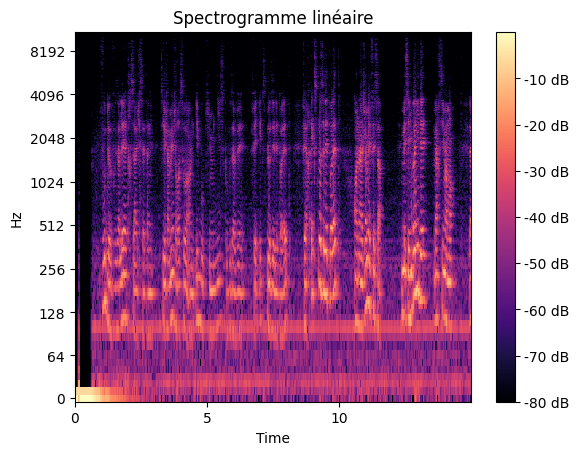

In [86]:
 # compute spectrogram for noisy voice signal
spec_voice = librosa.stft(aissa_audios[0])
spec_voice_db = librosa.amplitude_to_db(np.abs(spec_voice), ref=np.max)

# plot spectrogram for noisy voice signal
fig, ax = plt.subplots()
img = librosa.display.specshow(spec_voice_db, x_axis="time", y_axis="log", sr=22050)
_ = ax.set(title="Spectrogramme linéaire")
_ = fig.colorbar(img, ax=ax, format="%+2.f dB")

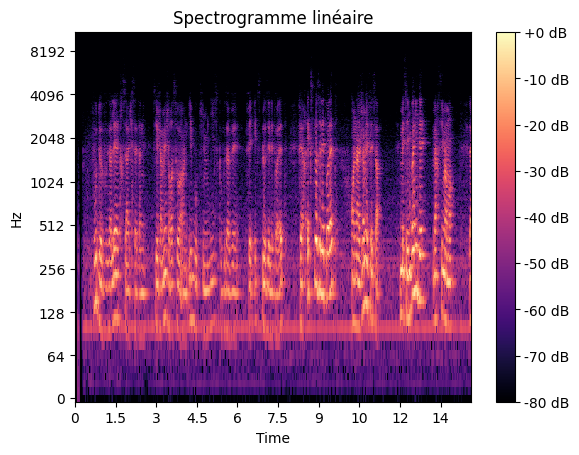

In [87]:
 # compute spectrogram for noisy voice signal
spec_voice = librosa.stft(aissa_audios_preprocessed[0])
spec_voice_db = librosa.amplitude_to_db(np.abs(spec_voice), ref=np.max)

# plot spectrogram for noisy voice signal
fig, ax = plt.subplots()
img = librosa.display.specshow(spec_voice_db, x_axis="time", y_axis="log", sr=22050)
_ = ax.set(title="Spectrogramme linéaire")
_ = fig.colorbar(img, ax=ax, format="%+2.f dB")

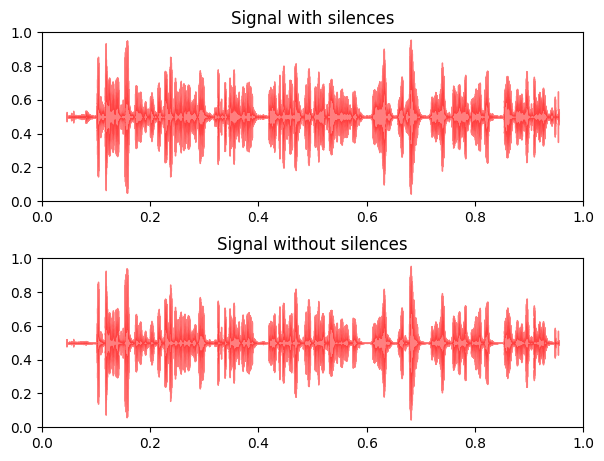

In [88]:
 # display waveform of voice signal with silences and without silence
fig, ax = plt.subplots(2,1)
fig.tight_layout(pad=2.0)

ax1 = fig.add_subplot(211)
ax1.axis('off')
ax1.set_title("Signal with silences")
_ = librosa.display.waveshow(marouan_audios[0], sr=22050, color='r', alpha=0.5)

ax2 = fig.add_subplot(212)
ax2.axis('off')
ax2.set_title("Signal without silences")
_ = librosa.display.waveshow(marouan_audios_preprocessed[0], sr=22050, color='r', alpha=0.5)

## Extraction des features

In [300]:
 # generate dataset from the audio signal, the samplerate and the label
def generate_dataset(audio, sr=22050):
    # generate Mel spectrogram
    spec = librosa.feature.melspectrogram(audio, sr=sr)
    
    # generate DataFrame from spectrogram (columns: frequencies, rows: analysis frames)
    X = pd.DataFrame(np.transpose(spec))
    return X

def generate_labels(df, label):
    y = pd.Series([label for row in range(df.shape[0])]) # pd.Series(label).repeat(X.shape[0])
    return y

In [301]:
df_list_aissa = [generate_dataset(audio) for audio in aissa_audios_preprocessed]
df_aissa = pd.concat(df_list_aissa)
y_aissa = generate_labels(df_aissa, "aissa")

df_list_marouan = [generate_dataset(audio) for audio in marouan_audios_preprocessed]
df_marouan = pd.concat(df_list_marouan)
y_marouan = generate_labels(df_marouan, "marouan")

df_list_autre = [generate_dataset(audio) for audio in autre_audios_preprocessed]
df_autre = pd.concat(df_list_autre)
y_autre = generate_labels(df_autre, "autre")


X = pd.concat([df_aissa, df_marouan, df_autre])
y = pd.concat([y_aissa, y_marouan, y_autre])

/tmp/ipykernel_5933/592335859.py:4: FutureWarning: Pass y=[-0.00063021  0.11837165  0.191553   ...  0.37487723  0.33487653
  0.29810628] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(audio, sr=sr)
/tmp/ipykernel_5933/592335859.py:4: FutureWarning: Pass y=[ 0.00052306  0.00011214 -0.00027935 ... -0.00216981 -0.00200042
 -0.00171573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(audio, sr=sr)
/tmp/ipykernel_5933/592335859.py:4: FutureWarning: Pass y=[-0.00063021  0.11837165  0.191553   ... -0.22022685 -0.16640567
 -0.10720403] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(audio, sr=sr)
/tmp/ipykernel_5933/592335859.py:4: FutureWarning: Pass y=[ 0.00084023 -0.00980655 -0.01799247 ...  0.00120777  0.00109173
  0.00098429]

## Entrainement et évaluation d'un modèle de ML

### Observation séparabilité des classes (PCA)

/home/marouan/.local/share/virtualenvs/speaker_recognition-0E-18EG4/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


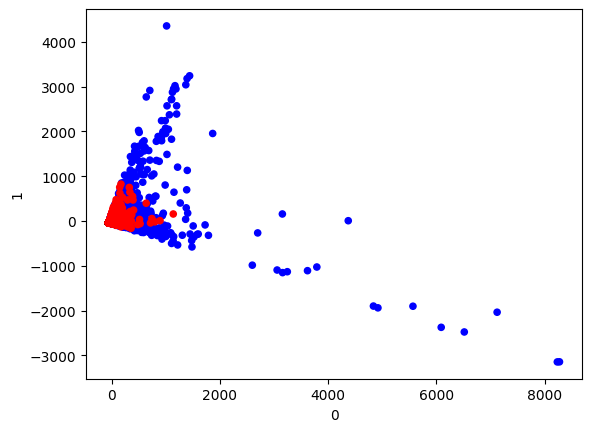

In [302]:
# observe the features using PCA decomposition over 2 dimensions
# classes clusters should be visually separable
pca = PCA(n_components=3)
X_pca = pd.DataFrame(pca.fit(X).transform(X))
_ = X_pca.plot.scatter(x=0, y=1, c=y.apply(lambda x: "red" if x == "autre" else "blue"), colormap="plasma")

### Split des données / Pipeline / Entraînement / Prédiction

In [303]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# # Pipeline lr
# pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('lr', LogisticRegression(random_state=42, max_iter=300))
# ])


# Pipeline randomforest
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, n_estimators=10, max_depth=10, max_leaf_nodes=70))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

### Evaluation / Export du modèle

In [304]:
 # compute the accuracy score
accuracy_score(y_test, y_pred)

0.8493975903614458

In [305]:
f1_score(y_test, y_pred, pos_label=pipe.classes_[1], average="weighted")

/home/marouan/.local/share/virtualenvs/speaker_recognition-0E-18EG4/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1386: UserWarning: Note that pos_label (set to 'autre') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


0.8483297976998098

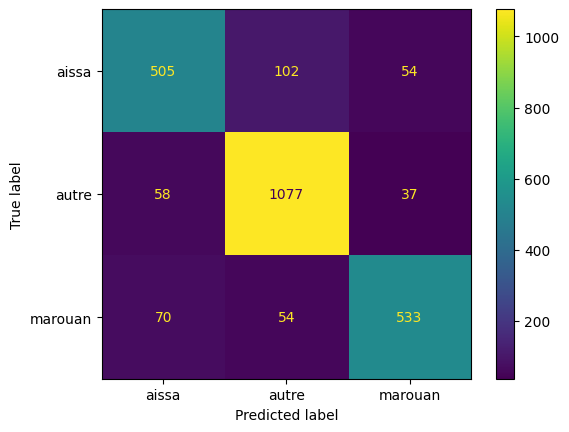

In [306]:
 # display the confusion matrix
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [307]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       aissa       0.80      0.76      0.78       661
       autre       0.87      0.92      0.90      1172
     marouan       0.85      0.81      0.83       657

    accuracy                           0.85      2490
   macro avg       0.84      0.83      0.84      2490
weighted avg       0.85      0.85      0.85      2490



Export du modèle

In [217]:
# dump(pipe, "rf_model.joblib")

['rf_model.joblib']

## Evaluation nouvel audio

In [308]:
samplerate = 48000  
duration = 5 # seconds
filename = 'eval.wav'

print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)
#reading the voice commands
samples, sample_rate = librosa.load(filename , sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)

start
end


/tmp/ipykernel_5933/217246239.py:13: FutureWarning: Pass orig_sr=16000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  samples = librosa.resample(samples, sample_rate, 8000)


In [309]:
audio, _ = librosa.load("eval.wav")

# generate the "nutcracker" input data (ignore label series)
X_eval = generate_dataset(pretraitment(audio), 22050)

# predict the label for each spectrogram frame of "nutcracker"
y_pred_eval = pipe.predict(X_eval)

# compute count of unique values for each label
eval_unique_labels, eval_unique_counts = np.unique(y_pred_eval, return_counts=True)
eval_unique_labels, eval_unique_counts

/tmp/ipykernel_5933/592335859.py:4: FutureWarning: Pass y=[-0.00063021  0.11837165  0.191553   ...  0.02221823  0.01948068
  0.01551573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.feature.melspectrogram(audio, sr=sr)


(array(['aissa', 'autre', 'marouan'], dtype=object), array([126,  60,  13]))

In [310]:
 # find the majority class of "nutcracker"
eval_unique_labels[np.argmax(eval_unique_counts)]

'aissa'